In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count

spark = SparkSession.builder.appName("MovieLensDataAnalysis").getOrCreate()


In [142]:
movies = spark.read.csv(r'C:\Users\Thinkpad\Desktop\ml-25m\movies.csv', header=True, inferSchema=True)
ratings = spark.read.csv(r'C:\Users\Thinkpad\Desktop\ml-25m\ratings.csv', header=True, inferSchema=True)
tags = spark.read.csv(r'C:\Users\Thinkpad\Desktop\ml-25m\tags.csv', header=True, inferSchema=True)


In [143]:
movies.show(5)
ratings.show(5)
tags.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
+------+-------+------+----------+
only showing top 5 rows

+------+-------+----------------+----------+
|userId|movieId|             tag| timestamp|
+------+-------+----------------+----------+
|     3|    260|         classic

## Distribution of Ratings:
I started by analyzing the distribution of ratings to understand how users rate movies. Using PySpark's groupBy and agg functions, I counted the number of occurrences for each rating.
We group by rating, count the occurrences, and sort the results.

In [72]:
rating_distribution = ratings.groupBy("rating").agg(count("rating").alias("count")).orderBy("rating")
rating_distribution.show()

+------+-------+
|rating|  count|
+------+-------+
|   0.5| 393068|
|   1.0| 776815|
|   1.5| 399490|
|   2.0|1640868|
|   2.5|1262797|
|   3.0|4896928|
|   3.5|3177318|
|   4.0|6639798|
|   4.5|2200539|
|   5.0|3612474|
+------+-------+



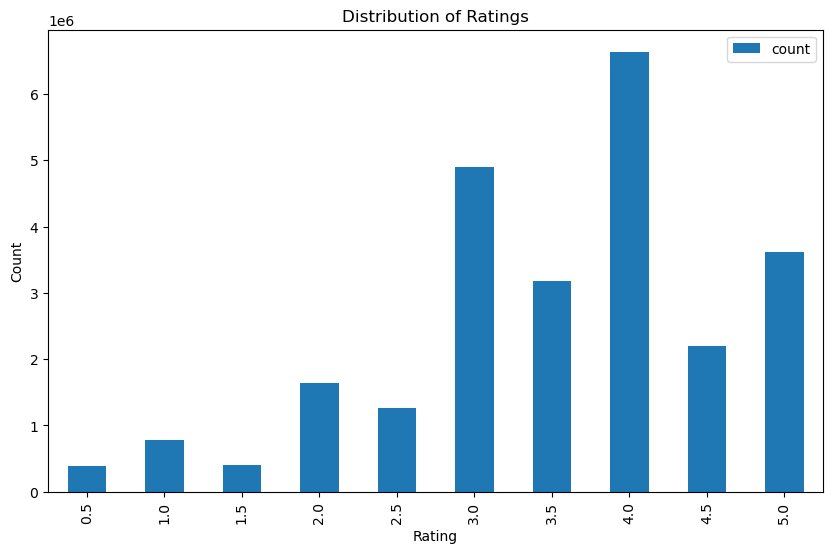

In [73]:
import matplotlib.pyplot as plt

# Assuming rating_distribution is already defined and created using PySpark

# Convert to Pandas DataFrame
rating_distribution_pd = rating_distribution.toPandas()

# Plot directly using Pandas plotting capabilities
rating_distribution_pd.plot(kind='bar', x='rating', y='count', 
                            figsize=(10, 6), title='Distribution of Ratings')

# Add labels and grid
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='', alpha=0.7)

# Show the plot
plt.show()


## Top Rated Movies:
Next, I identified the top-rated movies by joining the ratings with the movies dataset and calculating the average rating for each movie that received at least 20000 ratings.

In [144]:
from pyspark.sql.functions import avg

movie_ratings = ratings.groupBy("movieId").agg(avg("rating").alias("avg_rating"), count("rating").alias("rating_count"))
top_movies = movie_ratings.join(movies, on='movieId').filter("rating_count >= 20000").orderBy("avg_rating", ascending=False)
top_movies.show()


+-------+------------------+------------+--------------------+--------------------+
|movieId|        avg_rating|rating_count|               title|              genres|
+-------+------------------+------------+--------------------+--------------------+
|    318| 4.413576004516335|       81482|Shawshank Redempt...|         Crime|Drama|
|    858| 4.324336165187245|       52498|Godfather, The (1...|         Crime|Drama|
|     50| 4.284353213163313|       55366|Usual Suspects, T...|Crime|Mystery|Thr...|
|   1221|4.2617585117585115|       34188|Godfather: Part I...|         Crime|Drama|
|    527| 4.247579083279535|       60411|Schindler's List ...|           Drama|War|
|    904| 4.237947624243627|       20162|  Rear Window (1954)|    Mystery|Thriller|
|   2959| 4.228310618821568|       58773|   Fight Club (1999)|Action|Crime|Dram...|
|   1193|4.2186616007543405|       36058|One Flew Over the...|               Drama|
|    750| 4.215804447106386|       26714|Dr. Strangelove o...|          Come

## Most Active Users:
The most active users who have rated the most movies. This was done by grouping the data by userId and counting the number of ratings.

In [9]:
most_active_users = ratings.groupBy("userId").agg(count("rating").alias("rating_count")).orderBy("rating_count", ascending=False)
most_active_users.show()

+------+------------+
|userId|rating_count|
+------+------------+
| 72315|       32202|
| 80974|        9178|
|137293|        8913|
| 33844|        7919|
| 20055|        7488|
|109731|        6647|
| 92046|        6564|
| 49403|        6553|
| 30879|        5693|
|115102|        5649|
|110971|        5633|
| 75309|        5525|
| 78849|        5276|
| 61010|        5244|
| 29803|        5219|
|122011|        5160|
| 57548|        5066|
| 93855|        5045|
|103611|        4861|
| 34987|        4831|
+------+------------+
only showing top 20 rows



## Ratings Distribution by Year:
To observe trends over time, I extracted the year from the timestamp and counted the ratings for each year.

In [75]:
from pyspark.sql.functions import year, from_unixtime

ratings_with_year = ratings.withColumn("year", year(from_unixtime(ratings.timestamp)))
ratings_by_year = ratings_with_year.groupBy("year").agg(count("rating").alias("rating_count")).orderBy("year")
ratings_by_year.show()


+----+------------+
|year|rating_count|
+----+------------+
|1995|           3|
|1996|     1430089|
|1997|      626206|
|1998|      272040|
|1999|     1059022|
|2000|     1735458|
|2001|     1058231|
|2002|      776952|
|2003|      920500|
|2004|     1047911|
|2005|     1613560|
|2006|     1038413|
|2007|      931607|
|2008|     1018092|
|2009|      810107|
|2010|      792418|
|2011|      676560|
|2012|      635108|
|2013|      515529|
|2014|      478529|
+----+------------+
only showing top 20 rows



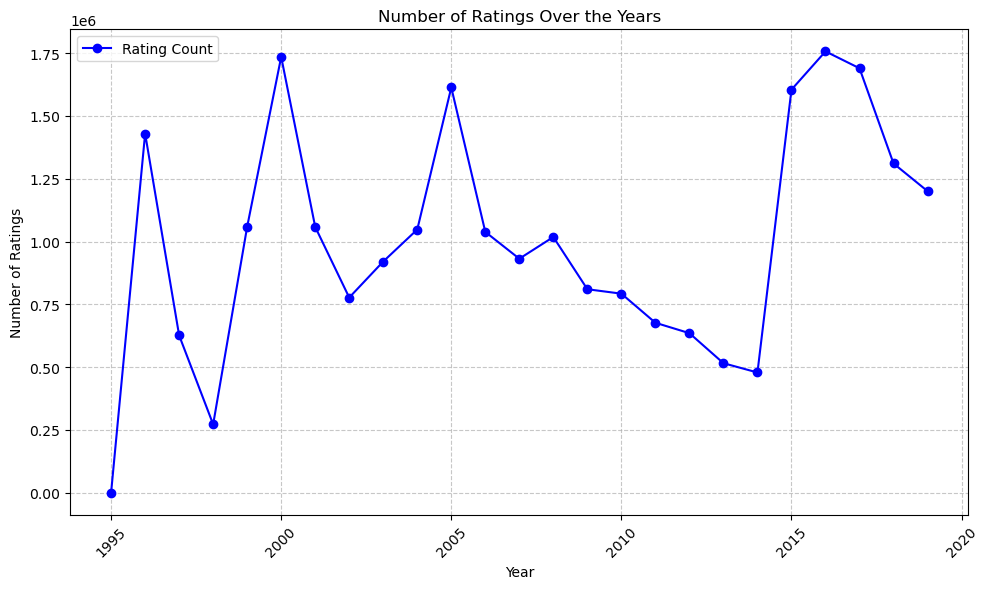

In [76]:
from pyspark.sql.functions import year, from_unixtime
import matplotlib.pyplot as plt

# Assuming ratings is your original DataFrame with columns like 'timestamp' and 'rating'
ratings_with_year = ratings.withColumn("year", year(from_unixtime(ratings.timestamp)))
ratings_by_year = ratings_with_year.groupBy("year").agg(count("rating").alias("rating_count")).orderBy("year")

# Convert to Pandas DataFrame
ratings_by_year_pd = ratings_by_year.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ratings_by_year_pd['year'], ratings_by_year_pd['rating_count'], marker='o', linestyle='-', color='b', label='Rating Count')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings Over the Years')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


We extract the year from the timestamp, group by year, and count the ratings for each year.
This line chart shows how the number of ratings has changed over the years, indicating user activity over time."

## Genres Analysis:

Finally, I performed a genres analysis by splitting the genres column and counting the occurrences of each genre.

In [77]:
from pyspark.sql.functions import explode, split

genres_expanded = movies.withColumn("genre", explode(split(movies.genres, "\\|")))
genre_distribution = genres_expanded.groupBy("genre").agg(count("genre").alias("count")).orderBy("count", ascending=False)
genre_distribution.show()


+------------------+-----+
|             genre|count|
+------------------+-----+
|             Drama|25606|
|            Comedy|16870|
|          Thriller| 8654|
|           Romance| 7719|
|            Action| 7348|
|            Horror| 5989|
|       Documentary| 5605|
|             Crime| 5319|
|(no genres listed)| 5062|
|         Adventure| 4145|
|            Sci-Fi| 3595|
|          Children| 2935|
|         Animation| 2929|
|           Mystery| 2925|
|           Fantasy| 2731|
|               War| 1874|
|           Western| 1399|
|           Musical| 1054|
|         Film-Noir|  353|
|              IMAX|  195|
+------------------+-----+



#  Train and Evaluate ALS Model

## **Model-Based Collaborative Filtering**

---



## **Collaborative filtering**


In [146]:
#inner join the movies dataframe with the ratings dataframe on the key 'moveID'

#need to create a column for movieID with a different name because two columns with the same name will exist in the joined dataframe
ratings = ratings.withColumn('movieID_duplicate',ratings['movieID']) 
df_ratings = ratings.drop('movieId') #drop the original column
df_ratings.show(5)
combined = movies.join(ratings, movies['movieID'] == ratings['movieID_duplicate']) #perform the join

+------+------+----------+-----------------+
|userId|rating| timestamp|movieID_duplicate|
+------+------+----------+-----------------+
|     1|   5.0|1147880044|              296|
|     1|   3.5|1147868817|              306|
|     1|   5.0|1147868828|              307|
|     1|   5.0|1147878820|              665|
|     1|   3.5|1147868510|              899|
+------+------+----------+-----------------+
only showing top 5 rows



In [147]:
combined.show(10)

+-------+--------------------+--------------------+------+-------+------+----------+-----------------+
|movieId|               title|              genres|userId|movieId|rating| timestamp|movieID_duplicate|
+-------+--------------------+--------------------+------+-------+------+----------+-----------------+
|    296| Pulp Fiction (1994)|Comedy|Crime|Dram...|     1|    296|   5.0|1147880044|              296|
|    306|Three Colors: Red...|               Drama|     1|    306|   3.5|1147868817|              306|
|    307|Three Colors: Blu...|               Drama|     1|    307|   5.0|1147868828|              307|
|    665|  Underground (1995)|    Comedy|Drama|War|     1|    665|   5.0|1147878820|              665|
|    899|Singin' in the Ra...|Comedy|Musical|Ro...|     1|    899|   3.5|1147868510|              899|
|   1088|Dirty Dancing (1987)|Drama|Musical|Rom...|     1|   1088|   4.0|1147868495|             1088|
|   1175| Delicatessen (1991)|Comedy|Drama|Romance|     1|   1175|   3.5|

In [148]:
combined = combined.drop('movieId') #we can now drop this column because we already have a moveId columns

In [100]:
combined.show(10)

+--------------------+--------------------+------+------+----------+-----------------+
|               title|              genres|userId|rating| timestamp|movieID_duplicate|
+--------------------+--------------------+------+------+----------+-----------------+
| Pulp Fiction (1994)|Comedy|Crime|Dram...|     1|   5.0|1147880044|              296|
|Three Colors: Red...|               Drama|     1|   3.5|1147868817|              306|
|Three Colors: Blu...|               Drama|     1|   5.0|1147868828|              307|
|  Underground (1995)|    Comedy|Drama|War|     1|   5.0|1147878820|              665|
|Singin' in the Ra...|Comedy|Musical|Ro...|     1|   3.5|1147868510|              899|
|Dirty Dancing (1987)|Drama|Musical|Rom...|     1|   4.0|1147868495|             1088|
| Delicatessen (1991)|Comedy|Drama|Romance|     1|   3.5|1147868826|             1175|
|          Ran (1985)|           Drama|War|     1|   3.5|1147878326|             1217|
|Seventh Seal, The...|               Drama|

In [149]:
combined = combined.withColumnRenamed('movieID_duplicate', 'movieId')

In [150]:
combined.show(10)

+--------------------+--------------------+------+------+----------+-------+
|               title|              genres|userId|rating| timestamp|movieId|
+--------------------+--------------------+------+------+----------+-------+
| Pulp Fiction (1994)|Comedy|Crime|Dram...|     1|   5.0|1147880044|    296|
|Three Colors: Red...|               Drama|     1|   3.5|1147868817|    306|
|Three Colors: Blu...|               Drama|     1|   5.0|1147868828|    307|
|  Underground (1995)|    Comedy|Drama|War|     1|   5.0|1147878820|    665|
|Singin' in the Ra...|Comedy|Musical|Ro...|     1|   3.5|1147868510|    899|
|Dirty Dancing (1987)|Drama|Musical|Rom...|     1|   4.0|1147868495|   1088|
| Delicatessen (1991)|Comedy|Drama|Romance|     1|   3.5|1147868826|   1175|
|          Ran (1985)|           Drama|War|     1|   3.5|1147878326|   1217|
|Seventh Seal, The...|               Drama|     1|   5.0|1147868839|   1237|
|Bridge on the Riv...| Adventure|Drama|War|     1|   4.0|1147868414|   1250|

### **Data Split** 

In [112]:
(training, test) = combined.randomSplit([0.8, 0.2], seed=1234)

### **a) Model Training**

An implementation of this algorithm is available in Spark ML.

In [113]:
from pyspark.ml.recommendation import ALS
# Train ALS model
als = ALS(maxIter=10, regParam=0.1, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
model = als.fit(training)


In [114]:
predictions = model.transform(test)

In [115]:
predictions.show() #show the first 20 predicted ratings

+--------------------+--------------------+------+------+----------+-------+----------+
|               title|              genres|userId|rating| timestamp|movieId|prediction|
+--------------------+--------------------+------+------+----------+-------+----------+
|Back to the Futur...|Adventure|Comedy|...|     1|   2.5|1147868079|   2011| 3.0983424|
|Barbarian Invasio...|Comedy|Crime|Dram...|     1|   3.5|1147869150|   6954|  3.933387|
|City of God (Cida...|Action|Adventure|...|     1|   5.0|1147869090|   6016| 4.1425705|
|Dolce Vita, La (1...|               Drama|     1|   5.0|1147868865|   8154| 3.7231991|
|Hit the Bank (Vab...|        Comedy|Crime|     1|   3.0|1147878698|   5912|  3.644559|
|Look at Me (Comme...|Comedy|Drama|Romance|     1|   5.0|1147879538|  32591| 3.5840385|
|M. Hulot’s Holida...|              Comedy|     1|   4.0|1147877986|   7209| 3.6580198|
| Moulin Rouge (2001)|Drama|Musical|Rom...|     1|   3.0|1147868534|   4308| 3.6435044|
|Night, The (Notte...|          

In [119]:
#compare the avg actual movie rating with the average predicted movie rating
predictions.groupBy('title').agg({'rating':'mean', 'prediction':'mean'}).show() 

+--------------------+------------------+------------------+
|               title|       avg(rating)|   avg(prediction)|
+--------------------+------------------+------------------+
|       Psycho (1960)| 4.050493716337522|3.9340909427730786|
|Men in Black (a.k...| 3.587758663674894|3.4781122587619353|
|I Love You Philli...|3.3348837209302324| 3.227427101135254|
|O Brother, Where ...|3.8749458170784568| 3.774914410318913|
|   Annie Hall (1977)| 4.062442748091603|3.9172617674783896|
|Seven Beauties (P...|3.8285714285714287|3.6348508335295175|
|Odd Couple II, Th...|2.4202127659574466|2.4537375575684486|
|22 Jump Street (2...| 3.529045643153527|3.4136428338363456|
|First Blood (Ramb...| 3.566234701223902| 3.473151892187614|
|Snow White and th...|3.5867977528089887|3.4892081563727237|
|    Elizabeth (1998)| 3.861708309122603| 3.771758656180369|
|When We Were King...| 4.084131326949384|3.9952318658580857|
|Night of the Livi...| 3.683755404570723| 3.545175216608831|
|Captain Corelli's...|2.

### **b) RMSE**

**RMSE on Test Set**

In [118]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

Root-mean-square error = 0.8033885174838004


So we have an RMSE of 0.80 rating points which is pretty good.

## Make Movie Recommendations
To make movie recommendations, we will pick a particular user, say userId = 100, and try to recommend that user movies which they haven't seen (or rated).

In [151]:
#calculate the number of different movies in the dataframe
num_unique_movies = combined.select('movieId').distinct().count()
print(num_unique_movies)

59047


In [152]:
unique_movies = combined.select('movieId').distinct().alias('unique_movies') #identify these different movies and store them in a dataframe

In [153]:
#identify the different movies taht userId 34987 has seen (or rated) and store them in a dataframe
new_userId = 34987
movies_rated = combined[combined['userId']==new_userId].select('movieId').distinct()
movies_rated = movies_rated.withColumn('rated_movieId', movies_rated['movieId'])
movies_rated = movies_rated.drop('movieId').alias('movies_rated')
movies_rated.count() #count how many different movies userId = 34987 has rated

4831

In [154]:
#identify which movies userId = 34987 has not yet rated by left joining the dataframe containing all the different movies in the dataset with the dataframe containing all the different movie rated by that user
the_movies = unique_movies.join(movies_rated,unique_movies.movieId == movies_rated.rated_movieId, how = 'left')
the_movies.show()

+-------+-------------+
|movieId|rated_movieId|
+-------+-------------+
|   1088|         1088|
|   1580|         1580|
|   3175|         NULL|
|  44022|         NULL|
| 175197|         NULL|
|   1645|         1645|
|    471|          471|
|   3794|         3794|
|   8638|         8638|
|  33722|         NULL|
|   2142|         NULL|
|   2366|         NULL|
|   6658|         6658|
|   1959|         1959|
|   6620|         6620|
|  54190|        54190|
|   3918|         NULL|
|  68135|         NULL|
|   1342|         1342|
|   1591|         NULL|
+-------+-------------+
only showing top 20 rows



In [155]:
#identify the different movies not yet rated by the user through boolean indexing (selecting only movies which exist in the database that haven't been rated by userId = 100)
unrated_movies = the_movies[the_movies['rated_movieId'].isNull()].select('movieId').distinct()
unrated_movies.show()

+-------+
|movieId|
+-------+
|   3175|
|  44022|
| 175197|
|  33722|
|   2142|
|   2366|
|   3918|
|  68135|
|   1591|
|   2122|
|   3997|
|  96488|
|  31528|
|  32460|
|    833|
|   4519|
|   4900|
|   5803|
|   7340|
|  97186|
+-------+
only showing top 20 rows



In [156]:
from pyspark.sql.functions import lit
#make predictions (i.e. recommendations) of movie ratings for all the movies that userId = 100 hasn't rated and sort them from the highest rating to the lowest

#set up the training dataframe with movieId for the unrated movies for userId = 100
unrated_movies = unrated_movies.withColumn('userId',lit(int(new_userId))) 

#make predictions
recommendations = model.transform(unrated_movies).orderBy('prediction',ascending = False)


In [131]:
recommendations.show()

+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
| 200930| 34987| 4.7370815|
| 205453| 34987|  4.545529|
| 203882| 34987| 4.5305405|
| 196787| 34987| 4.3626275|
| 194334| 34987|  4.352656|
| 194434| 34987|  4.350729|
| 192089| 34987|  4.262832|
| 201821| 34987|  4.232757|
| 151615| 34987|  4.213497|
| 204302| 34987|  4.192991|
| 143192| 34987|  4.184909|
| 159467| 34987|  4.170185|
| 208597| 34987| 4.1534467|
| 166812| 34987| 4.1429358|
| 153036| 34987|  4.130482|
| 153038| 34987|  4.130482|
| 150860| 34987|  4.123911|
| 187949| 34987|   4.12147|
| 187951| 34987|   4.12147|
| 187947| 34987|   4.12147|
+-------+------+----------+
only showing top 20 rows



In [158]:
#display the movie title by inner joining the recommendations dataframe with the df_movies dataframe that contains the movie titles on the key - movieID
recommendations.join(movies,recommendations['movieId'] == movies['movieId']).select('title','prediction').orderBy('prediction', ascending = False).show()

+--------------------+----------+
|               title|prediction|
+--------------------+----------+
|C'est quoi la vie...| 4.7370815|
|The Good Fight: T...|  4.545529|
|Dead in the Water...| 4.5305405|
|The Law and the F...| 4.3626275|
|Les Luthiers: El ...|  4.352656|
|   Adrenaline (1990)|  4.350729|
|National Theatre ...|  4.262832|
| Civilisation (1969)|  4.232757|
|Hello Stranger (2...|  4.213497|
|Ek Ladki Ko Dekha...|  4.192991|
|Blow for Blow (1972)|  4.184909|
|Fifi Howls from H...|  4.170185|
|Punk the Capital:...| 4.1534467|
|Seeing Red: Stori...| 4.1429358|
|     Acéphale (1969)|  4.130482|
|       Avetik (1992)|  4.130482|
|    Flag Wars (2003)|  4.123911|
| Furious Love (2010)|   4.12147|
|Father of Lights ...|   4.12147|
|Finger of God (2007)|   4.12147|
+--------------------+----------+
only showing top 20 rows

